In [39]:
import pandas as pd

from pyecharts.globals import CurrentConfig, OnlineHostType
CurrentConfig.ONLINE_HOST = OnlineHostType.NOTEBOOK_HOST
# 读取数据
data = pd.read_csv('output.csv')

正式开始
# 1. 分析发布部门占比
### 1.1 各部门数量及总数

In [40]:
counter_series = data['department'].value_counts()
total_count = counter_series.sum()  # 计算总数
print(counter_series)
print(f"总数：{total_count}")

department
【教学运行】    1609
【实践科】      892
【教研教改】     434
【综合科】      401
【质量办】      331
【计划科】      190
【教学通知】      56
【教材中心】      26
Name: count, dtype: int64
总数：3939


### 1.2 发布部门占比饼图

In [41]:
from pyecharts import options as opts
from pyecharts.charts import Pie
from pyecharts.globals import CurrentConfig,OnlineHostType,ThemeType
CurrentConfig.ONLINE_HOST = OnlineHostType.NOTEBOOK_HOST
pie1 = (
    Pie(init_opts=opts.InitOpts(width="1000px", height="900px",theme=ThemeType.DARK))  # 调整画面大小
    .add("", [list(z) for z in zip(counter_series.index, [int(i) for i in counter_series.values])])
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%({c})"))  # 修改为显示比例和数量
)
pie1.load_javascript()
pie1.set_global_opts(
    title_opts=opts.TitleOpts(title=f"发布部门占比(总数{total_count})", pos_left="3%", pos_top="3%"),  # 将图往下移动
    legend_opts=opts.LegendOpts(pos_bottom="2%"),  # 修改图例位置到下方
)
pie1.render_notebook()

# 2. 分析附件下载次数与通知人的关系
### 2.1 各部门下载次数

In [42]:
data = pd.read_csv('output.csv')
# 数据清洗：去除 downloaded_all 列中为空的行
data = data.dropna(subset=['downloaded_all'])
# 将 downloaded_all 列转换为数值类型
data['downloaded_all'] = pd.to_numeric(data['downloaded_all'], errors='coerce')
# 去除 department 列中部门名称两边的【】符号
data['department'] = data['department'].str.replace(r'【|】', '', regex=True)
# 按部门统计 downloaded_all 的总和
department_downloads = data.groupby('department')['downloaded_all'].sum().reset_index()

print(department_downloads)

  department  downloaded_all
0        实践科        355996.0
1       教学运行        158501.0
2       教学通知         11773.0
3       教材中心         32255.0
4       教研教改         90656.0
5        综合科         16460.0
6        计划科         38607.0
7        质量办         62696.0


可得结论，实践科是大家都有所关注和下载的，也有可能是它附件多。
而教学通知或许是往往没人看的，也可能是它附件少

### 2.2 各部门下载次数柱状图

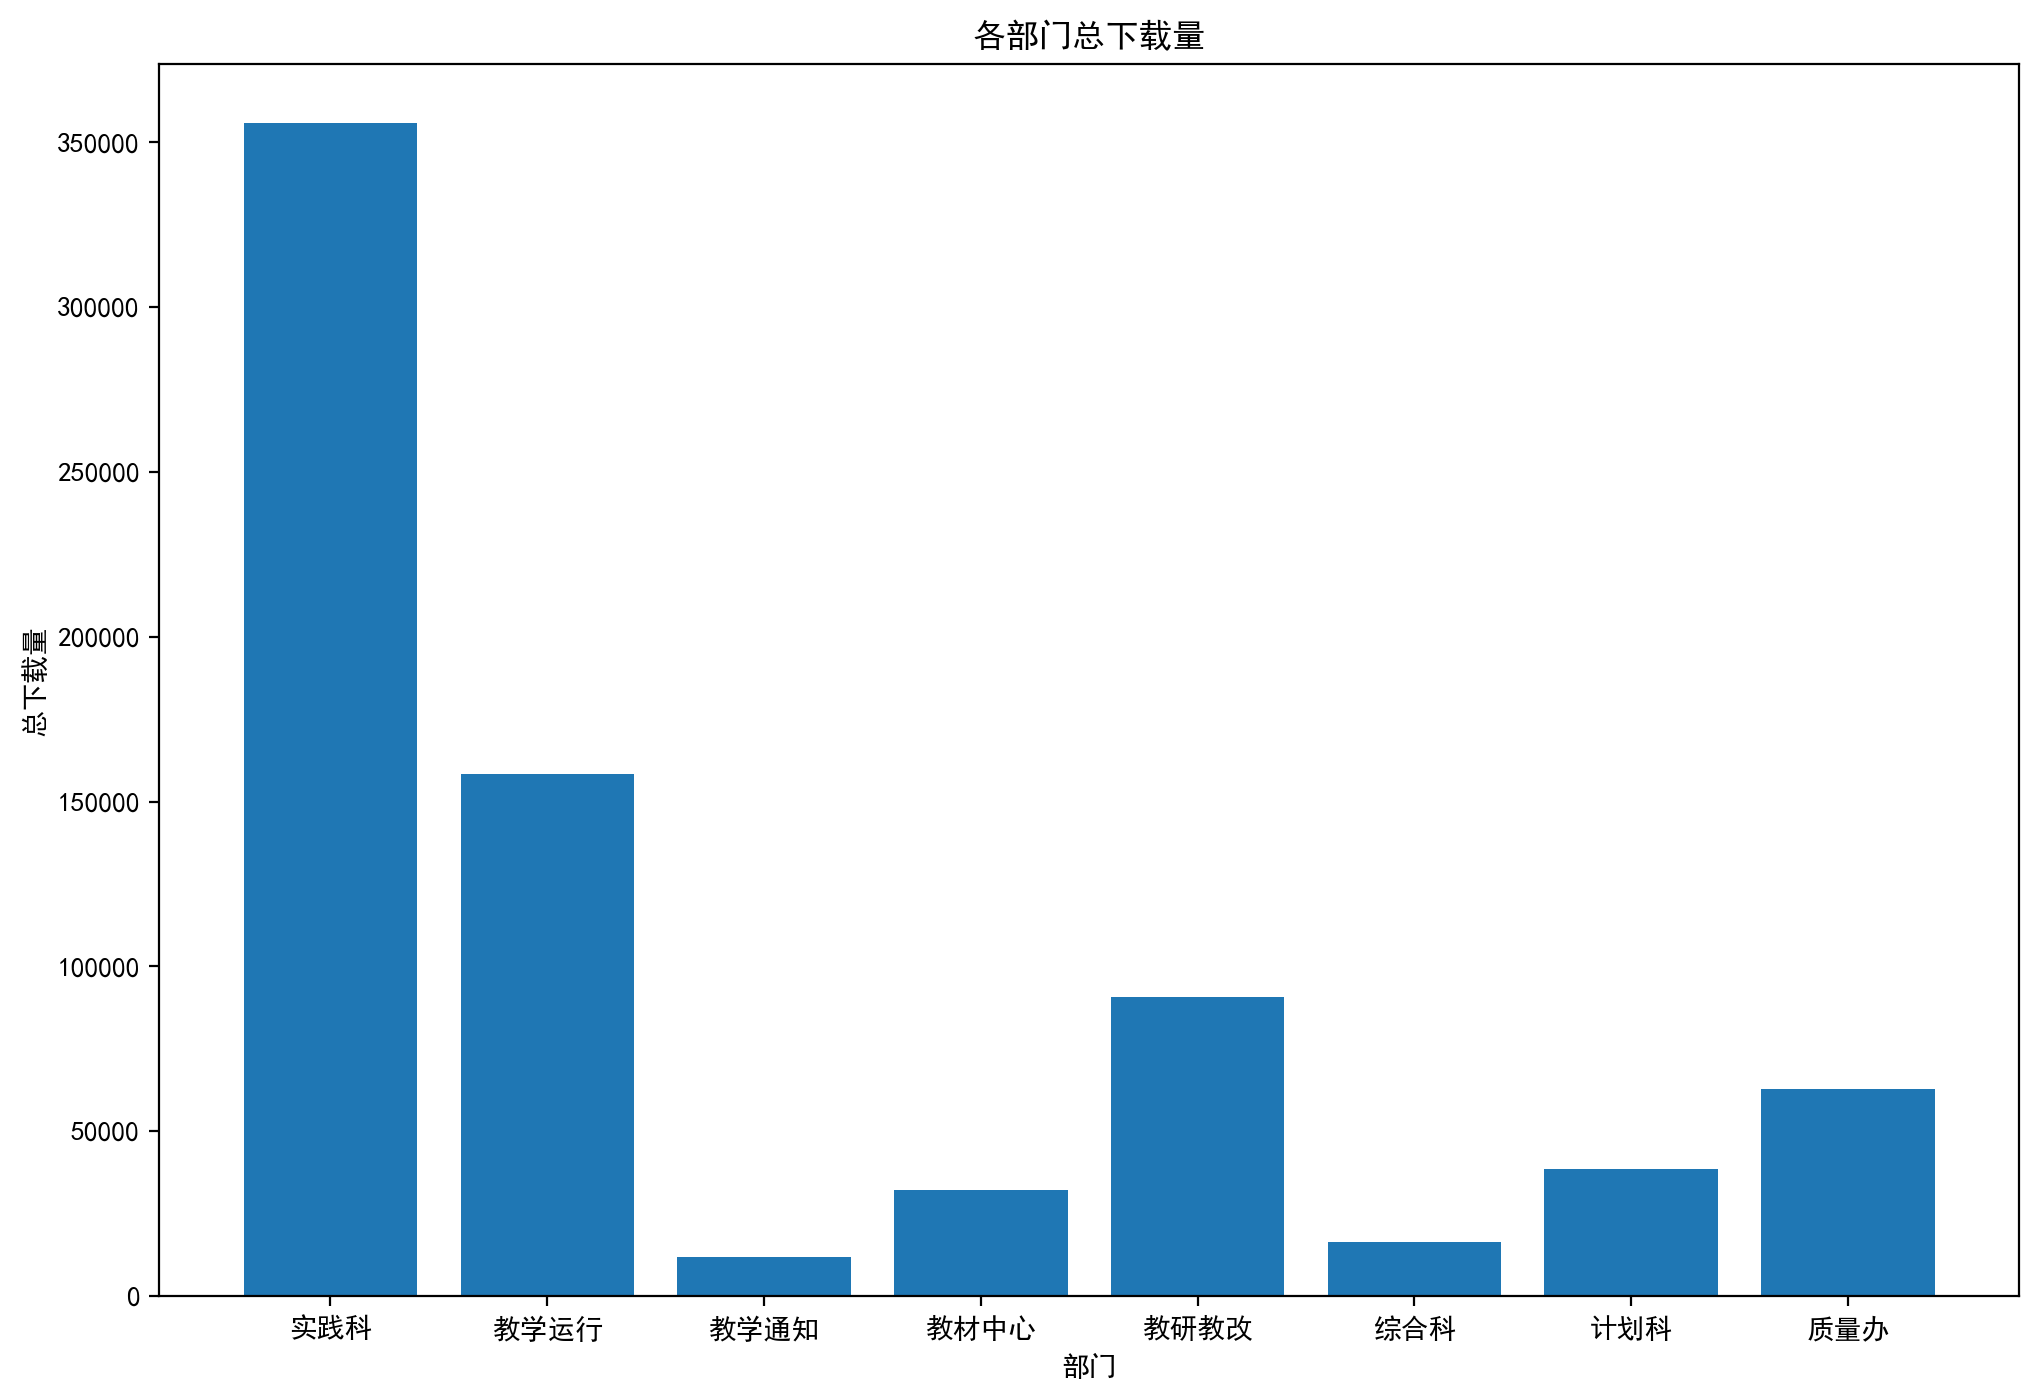

In [44]:
import matplotlib.pyplot as plt
# 设置字体和 DPI
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体，确保能显示中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.figure(figsize=(12, 8), dpi=200)  # 设置图表大小和清晰度

# 绘制柱状图
plt.bar(department_downloads['department'], department_downloads['downloaded_all'])
plt.xlabel('部门')
plt.ylabel('总下载量')
plt.title('各部门总下载量')
plt.show()

### 2.3 下载量与附件数量比值
由上面结论留下的问题，计算每个部门附件的平均下载量


In [23]:
import pandas as pd
data = pd.read_csv('output.csv')
# 计算每个部门的总下载量和总附件数
department_downloads = data.groupby('department')
department_downloads = department_downloads.agg({'downloaded_all': 'sum', 'attachment': 'sum'})
department_downloads['rate']=department_downloads['downloaded_all']/department_downloads['attachment']
print(department_downloads.sort_values(by='rate',ascending=False))


            downloaded_all  attachment         rate
department                                         
【实践科】             355996.0       228.0  1561.385965
【计划科】              38607.0        25.0  1544.280000
【教研教改】             90656.0        80.0  1133.200000
【教学运行】            158501.0       153.0  1035.954248
【质量办】              62696.0        78.0   803.794872
【综合科】              16460.0        22.0   748.181818
【教材中心】             32255.0        51.0   632.450980
【教学通知】             11773.0        22.0   535.136364


这样一来，就很明显了。
平均发1个附件的下载量实践科确实是遥遥领先，同时它也是发附件最多的部门
计划科也不少，但是附件总数少。
而教学通知仍然是最后的，说明它发的附件确实没什么人看

由此可见，下载次数和通知部门还是挺有关系的

# 3. 统计每天的通知数，分析哪段时间通知比较密集
### 3.1 每天通知数

In [24]:

import pandas as pd
from pyecharts.charts import Line
from pyecharts import options as opts
from pyecharts.globals import ThemeType
data = pd.read_csv('output.csv')
# 假设 data 中包含 'time' 列，首先删除空值并转换为日期类型
data = data.dropna(subset=['time'])
data['time'] = pd.to_datetime(data['time'], errors='coerce')
# 按时间排序并将 'time' 设为索引
data = data.set_index('time').sort_index()

# 以天为单位进行重采样，并对没有记录的日期自动填充 0
daily_notifications = data.resample('D').size().reset_index(name='count')

daily_notifications


,time,count
0,2002-10-28,1
1,2002-10-29,0
2,2002-10-30,0
3,2002-10-31,0
4,2002-11-01,0
...,...,...
8092,2024-12-23,1
8093,2024-12-24,4
8094,2024-12-25,5
8095,2024-12-26,0


### 3.2 每天通知数的折线图
##### 3.2.1

In [25]:
from pyecharts.charts import Line
from pyecharts import options as opts
from pyecharts.globals import ThemeType
# 使用 pyecharts 绘制每天通知数的折线图
line = (
    Line(init_opts=opts.InitOpts(theme=ThemeType.DARK, width="1000px", height="600px"))
    .add_xaxis(daily_notifications['time'].dt.strftime('%Y-%m-%d').tolist())
    .add_yaxis("通知数", daily_notifications['count'].tolist(), is_smooth=True)
    .set_global_opts(
        title_opts=opts.TitleOpts(title="每天的通知数", pos_left="1%", pos_top="1%"),
        xaxis_opts=opts.AxisOpts(type_="category", name="日期"),
        yaxis_opts=opts.AxisOpts(name="通知数"),
        datazoom_opts=[opts.DataZoomOpts(), opts.DataZoomOpts(type_="inside")],
        tooltip_opts=opts.TooltipOpts(trigger="axis"),
    )
)

line.render_notebook()

    由此可以发现单纯的折线图杂乱无章，得不出什么有用的信息
##### 3.2.2 等距离散化days数据

In [26]:
import pandas as pd

# 设置时间间隔并进行分组统计
days = 75
days_notifications = (
    daily_notifications
    .groupby(pd.Grouper(key='time', freq=f'{days}D'))
    .sum()  
    .reset_index()
)
print(f"\n每{days}天通知数统计:")
print(days_notifications)
print(f"最多区间：{days_notifications.where(days_notifications['count'] == days_notifications['count'].max()).dropna()}")
print(f"最少区间：{days_notifications.where(days_notifications['count'] == days_notifications['count'].min()).dropna()}")
print(f"平均通知数：{days_notifications['count'].mean()}")
print(f"中位数通知数：{days_notifications['count'].median()}")



每75天通知数统计:
          time  count
0   2002-10-28      3
1   2003-01-11      6
2   2003-03-27     10
3   2003-06-10      0
4   2003-08-24      9
..         ...    ...
103 2023-12-22     35
104 2024-03-06     53
105 2024-05-20     43
106 2024-08-03     49
107 2024-10-17     50

[108 rows x 2 columns]
最多区间：         time  count
60 2015-02-22   75.0
最少区间：        time  count
3 2003-06-10    0.0
平均通知数：36.47222222222222
中位数通知数：37.5


In [27]:
# 绘制折线图
line = (
    Line(init_opts=opts.InitOpts(theme=ThemeType.DARK, width="1000px", height="600px"))
    .add_xaxis(days_notifications['time'].dt.strftime('%Y-%m-%d').tolist())
    .add_yaxis(
        f"{days}天总数",
        days_notifications['count'].tolist(), 
        is_smooth=True,
        areastyle_opts=opts.AreaStyleOpts(opacity=0.4)
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title=f"每 {days} 天的通知数", pos_left="1%", pos_top="1%"),
        xaxis_opts=opts.AxisOpts(name="日期"),
        yaxis_opts=opts.AxisOpts(name="通知数"),
        datazoom_opts=[opts.DataZoomOpts(), opts.DataZoomOpts(type_="inside")],
    )
)
line.render_notebook()

虽然还是不太明朗，但是我们已经可以很明显的看到几个区间的通知书的数量很多。例如：2007-02-19以来150天，2012-1-24以来75天，2015-2-22以来150天，2017-0313以来75天，2017-10-24以来150天，2019-8-30日以来150天，2021-4-21以来75天，2022-2-15以来150天。

### 3.3 按月分组,形成柱状图
##### 3.3.1 统计
一个20年的跨度实在是太长，在经过日期等距离散化后仍然不够清晰。又考虑到学校的通知书或许在年上有周期性，因此按月分组，看看不同月份的通知数量

In [28]:
data = pd.read_csv('output.csv')
# 假设 data 中包含 'time' 列，首先删除空值并转换为日期类型
data = data.dropna(subset=['time'])
data['time'] = pd.to_datetime(data['time'], errors='coerce')
# 将time列转换为datetime类型
data['time'] = pd.to_datetime(data['time'])
# 提取月份信息,并添加到data中
data['month'] = data['time'].dt.month

# 按月份分组统计
monthly_stats = data.groupby('month').size()

print("\n各月份通知数量统计：")
print(monthly_stats)



各月份通知数量统计：
month
1     256
2     186
3     367
4     410
5     405
6     492
7     147
8     163
9     499
10    277
11    308
12    429
dtype: int64


##### 3.3.2月统计柱状图

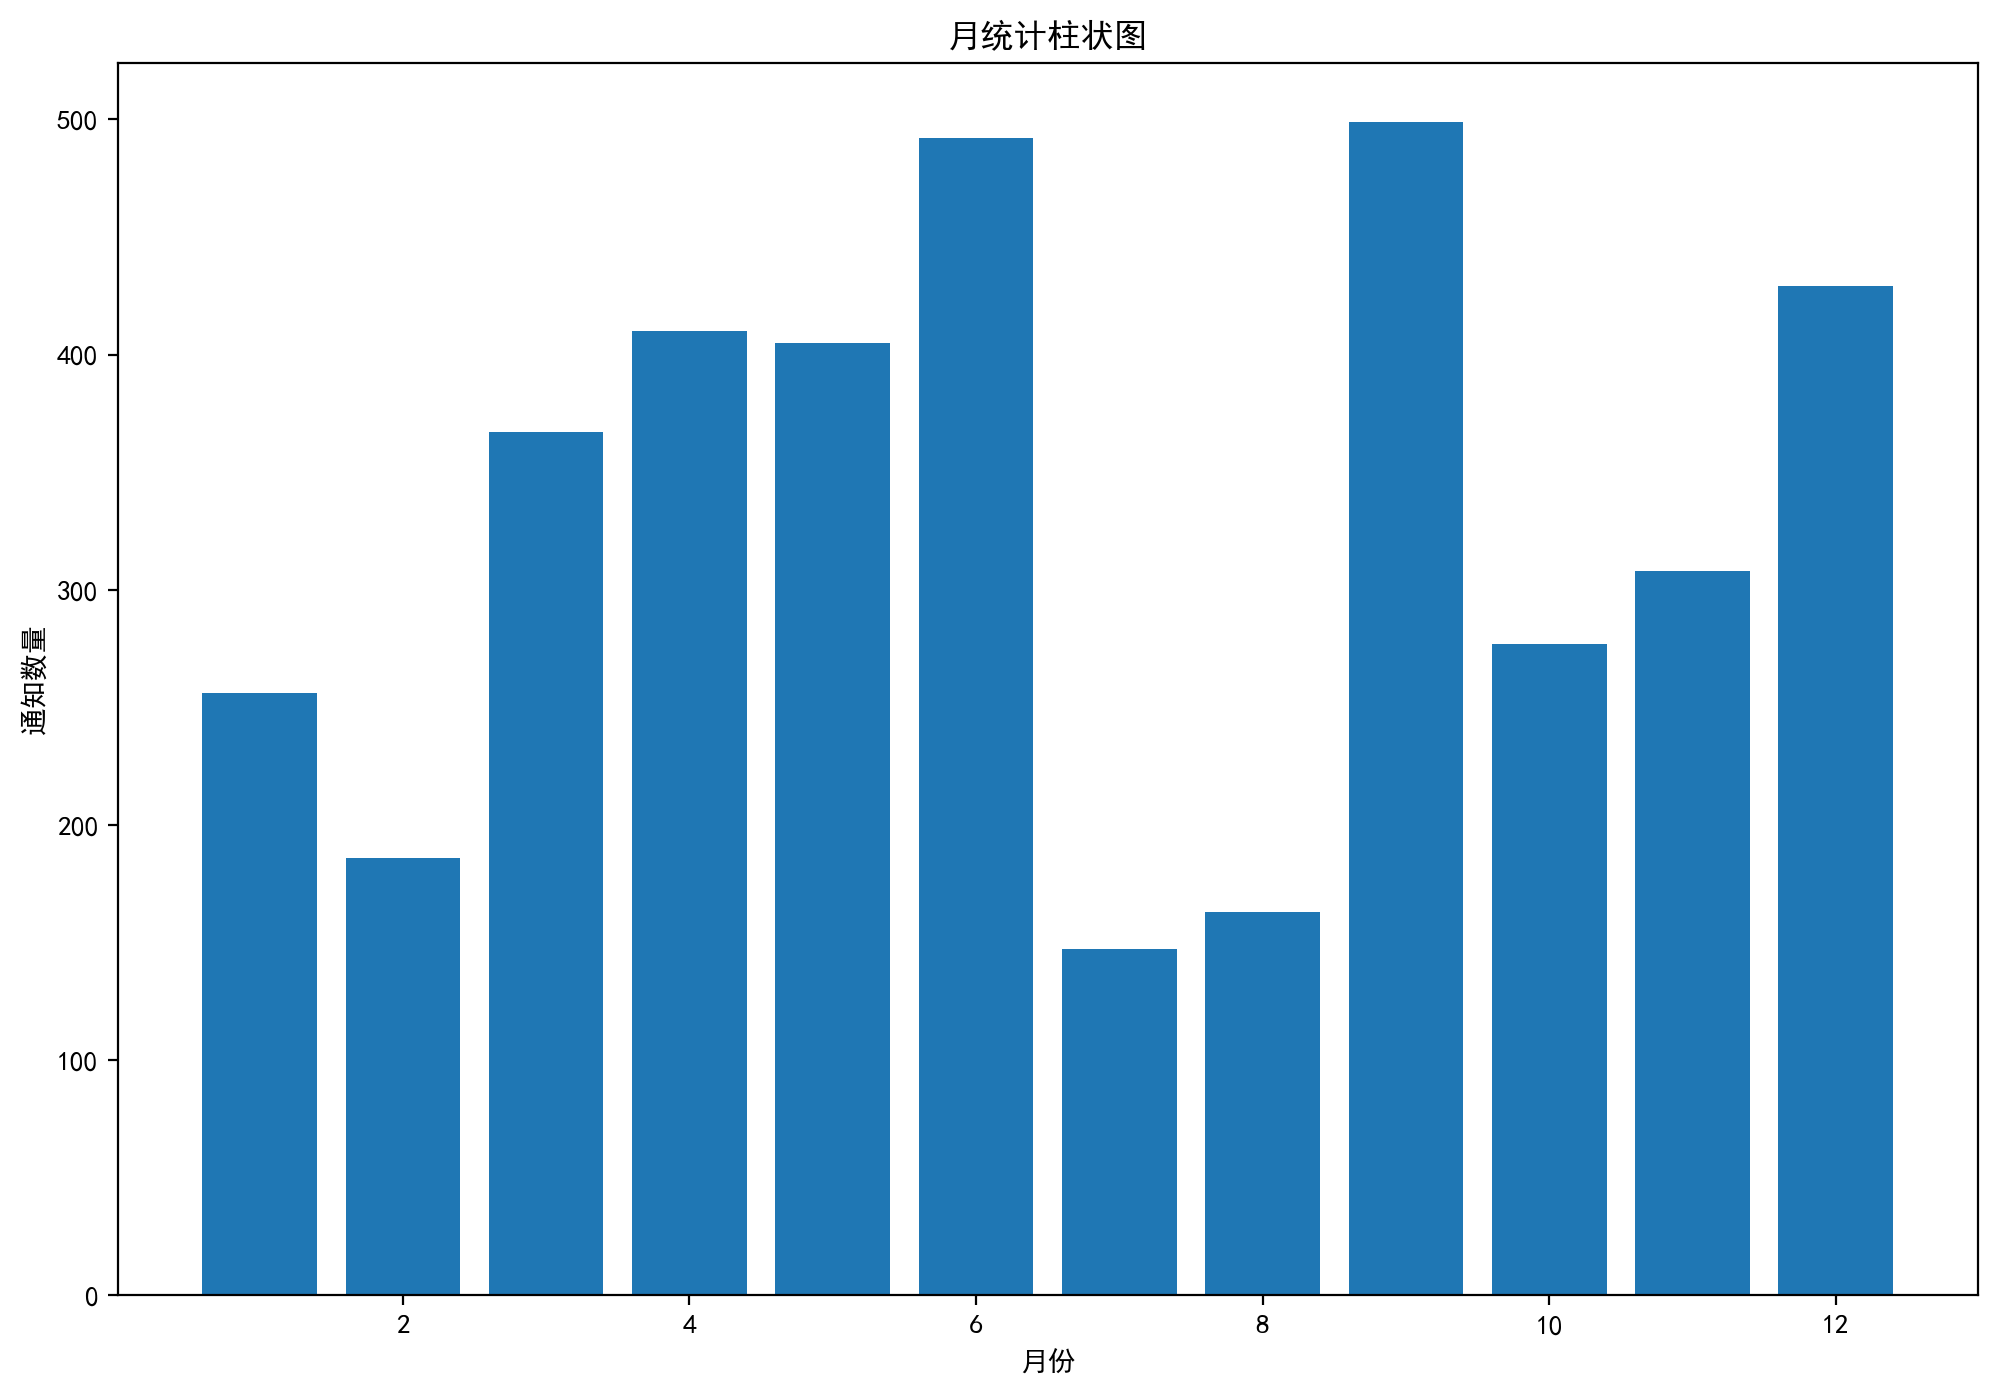

In [37]:
import matplotlib.pyplot as plt
# 设置字体和 DPI
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体，确保能显示中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.figure(figsize=(12, 8), dpi=200)  

# 绘制柱状图
plt.bar(monthly_stats.index, monthly_stats.values)
plt.xlabel('月份')
plt.ylabel('通知数量')
plt.title('月统计柱状图')
plt.show()

显然，通过观察，可以得到以下结论：
- 在每年的学年初9月和毕业季6月，通知是最多的。
- 在寒假1月与暑假7、8月的通知数量大大少于学期间的
- 后半学年的通知数量常大于前半学年的通知数量


# 4. 各部门通知数量排行榜变化
奇思妙想了，或许每个部门的年份是不同的

### 4.1 将时间等距分割为3个月，统计各个部门在区间上的通知总数

In [30]:
import pandas as pd

df = pd.read_csv('d:/Learn/west2_task2/爬取教务处//output.csv')

# 确保时间列格式正确
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# 提取年份和季度信息
df['year_quarter'] = df['time'].dt.to_period('Q')

# 按部门和季度统计通知总数
quarterly_stats = df.groupby(['department', 'year_quarter']).size().reset_index(name='sum')
print(quarterly_stats)

# 获取所有部门和季度
departments = quarterly_stats['department'].unique()
quarters = sorted(quarterly_stats['year_quarter'].unique())
quarters_txt = [str(q) for q in quarters]
quarters_txt.sort()


    department year_quarter  sum
0        【实践科】       2006Q2    5
1        【实践科】       2006Q3    3
2        【实践科】       2006Q4    6
3        【实践科】       2007Q1    5
4        【实践科】       2007Q2    3
..         ...          ...  ...
423      【质量办】       2023Q4    5
424      【质量办】       2024Q1    3
425      【质量办】       2024Q2    5
426      【质量办】       2024Q3    8
427      【质量办】       2024Q4   12

[428 rows x 3 columns]


### 4.2 生成每个部门在这20年里的通知数折线图

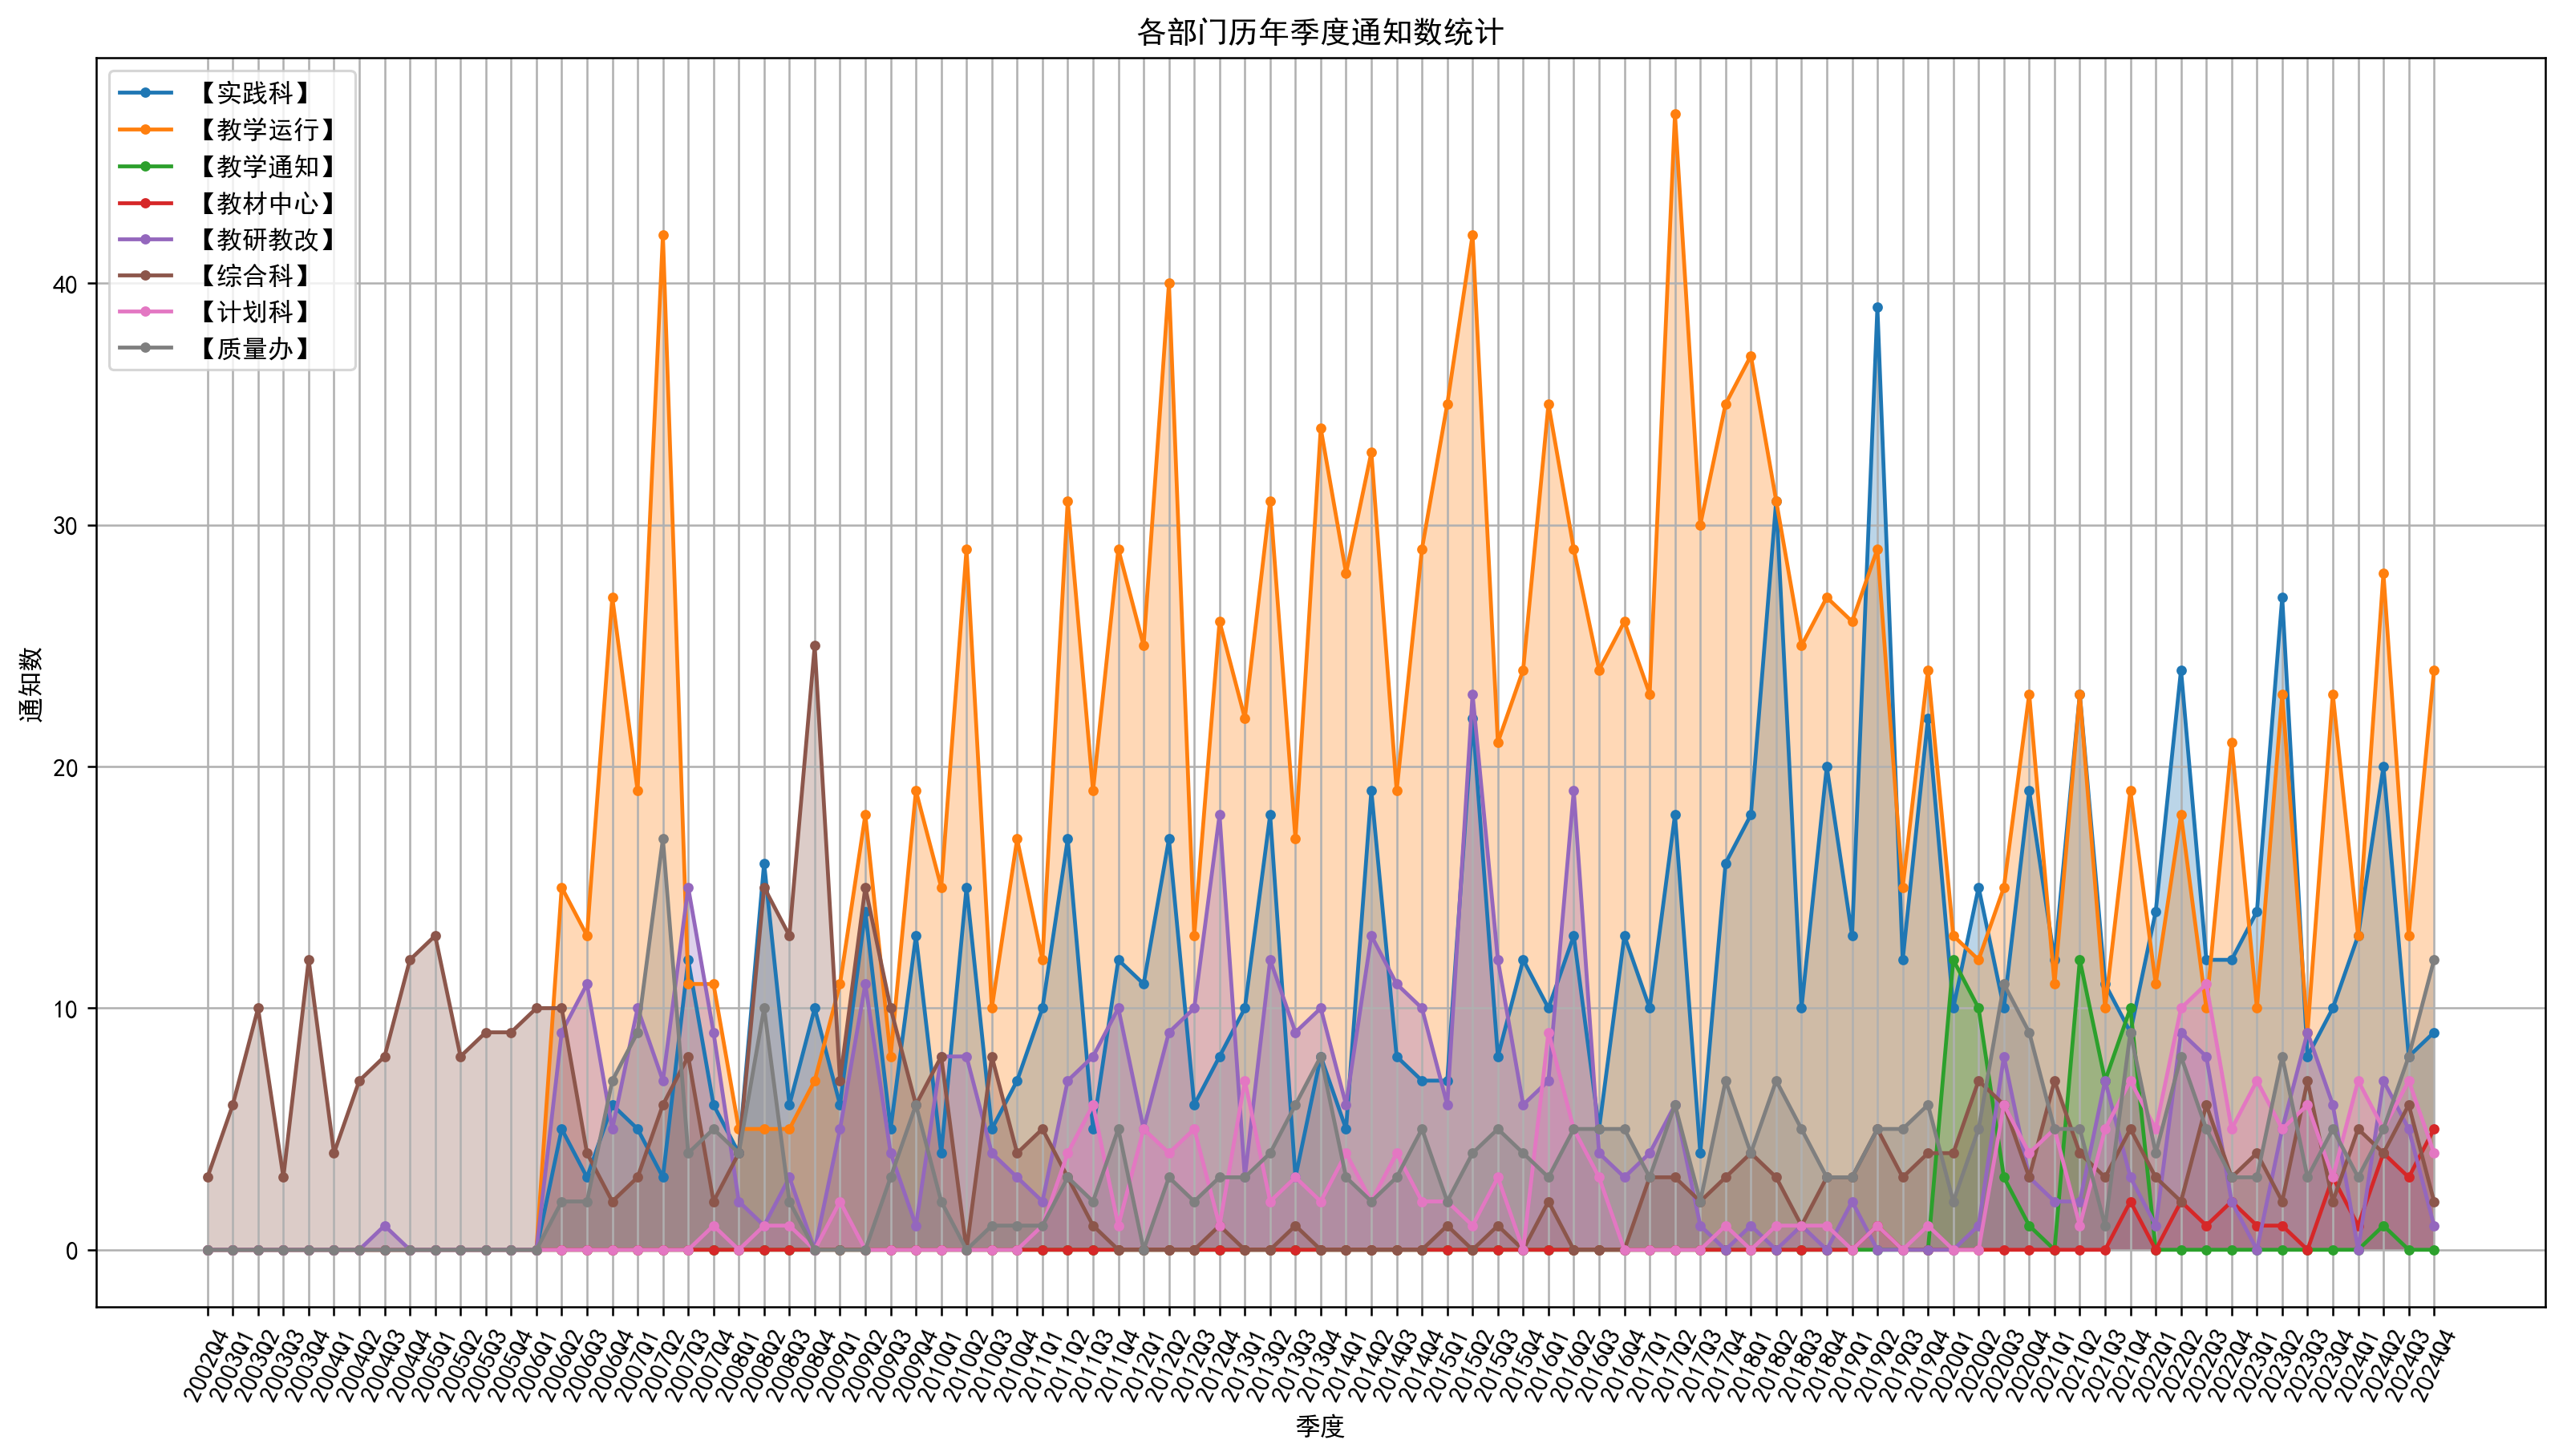

In [45]:
import matplotlib.pyplot as plt

# 创建折线图
plt.figure(figsize=(14, 8), dpi=700)

# 添加每个部门的y轴数据
for department in departments:
    dept_data = quarterly_stats[quarterly_stats['department'] == department]
    y_data = [dept_data[dept_data['year_quarter'] == q]['sum'].values[0] if q in dept_data['year_quarter'].values else 0 for q in quarters]
    plt.plot(quarters_txt, y_data, label=department, drawstyle='default', marker='o', markersize=3)
    plt.fill_between(quarters_txt, y_data, alpha=0.3)

# 设置图表标题和标签
plt.title("各部门历年季度通知数统计")
plt.xlabel("季度")
plt.ylabel("通知数")
plt.xticks(rotation=65)
plt.legend(loc='upper left')
plt.grid(True)

# 显示图表
plt.tight_layout()
plt.show()

结论：
- 早年，综合科统领着教务处通知，几乎所有通知都由其发出。后来随着时代变迁，渐渐销声匿迹。
- 2005年末，各个部门加入混战，教学运行一鸣惊人，力压所有部门，即使在2007-2009年间被原来的头子综合科压迫至低谷，但仍生生不息。在2010年逐渐夺回属于自己的位置，并在2011-2019十年间始终处于绝对统领的地位。
- 2010-2019年。这是一段被教学运行统治的时期，但各个不同部门也在杂乱生长。比如质量办，计划科，教研教改，它们常常不温不火。但还有一位例外：实践科。它在这十年间，虽然时常数量不及教学运行一半，但是它稳固的占据了排行榜的第二，并且不断壮大。
- 2019-至今。2019是一个重要的年份，在这一年，教学运行的数量锐减。而实践科在天时地利人和之下，成功的夺下第一。至此，天下二分局面已定，至今如此。此外，在这段期间内，又有两个新部门参与了这场混乱：教材中心和教学通知。教学通知曾在2019-2021兴盛一时，力压一些老部门，但如今也沉寂。教材中心则是才刚刚起步，表现一般。
- 现状。实践科似乎已经摆烂躺平，而教学中心呈昂扬之势，似乎马上就要终结这场争霸。另外，还有一老部门质量办，正悄悄谋划着不为人知的计策，数量平地起飞，跃升至第二，让我们期待它接下来的表现。

### 4.3动态变化图

In [15]:
from pyecharts.charts import Bar, Timeline
from pyecharts.options import *
from pyecharts.globals import ThemeType
import pandas as pd

df = pd.read_csv('d:/Learn/west2_task2/爬取教务处/output.csv')

# 确保时间列格式正确
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# 提取年份和季度信息
df['year_quarter'] = df['time'].dt.to_period('Q')

# 将数据按季度分组后部门统计
quarterly_stats = df.groupby(['year_quarter','department' ]).size().reset_index(name='sum')
quarterly_stats['year_quarter'] = quarterly_stats['year_quarter'].astype(str)
quarterly_stats.sort_values(by='year_quarter', inplace=True)
print(quarterly_stats)
dictx = {}
for index, row in quarterly_stats.iterrows():
    if row['year_quarter'] not in dictx:
        dictx[row['year_quarter']] = []
    dictx[row['year_quarter']].append((row['department'], row['sum']))


timeline = Timeline({"theme": ThemeType.DARK})
for year in quarters_txt:
    quarter_data = sorted(dictx[year],key=lambda element: element[1], reverse=True)

    x_data = []
    y_data = []
    for i in quarter_data:
        x_data.append(i[0])  
        y_data.append(i[1])

    # 构建柱状图
    bar = Bar()
    x_data.reverse()
    y_data.reverse()
    bar.add_xaxis(x_data)
    bar.add_yaxis("", y_data, label_opts=LabelOpts(formatter="{c}"))
    # 反转x轴和y轴
    bar.reversal_axis()
    # 设置每一年的图表的标题
    bar.set_global_opts(
        title_opts=TitleOpts(title=f"{year}季度通知数统计", pos_left="2%", pos_top="3%"), 
        toolbox_opts=ToolboxOpts(is_show=False),
        legend_opts=LegendOpts(is_show=False)               
    )
    timeline.add(bar, str(year))

# for循环每一年的数据，基于每一年的数据，创建每一年的bar对象
# 在for中，将每一年的bar对象添加到时间线中

# 设置时间线自动播放
timeline.add_schema(
    play_interval=1000,
    is_timeline_show=True,
    is_auto_play=True,
    is_loop_play=False
)
# 绘图
timeline.render_notebook()



    year_quarter department  sum
0         2002Q4      【综合科】    3
1         2003Q1      【综合科】    6
2         2003Q2      【综合科】   10
3         2003Q3      【综合科】    3
4         2003Q4      【综合科】   12
..           ...        ...  ...
422       2024Q4     【教学运行】   24
423       2024Q4     【教材中心】    5
424       2024Q4     【教研教改】    1
425       2024Q4      【综合科】    2
427       2024Q4      【质量办】   12

[428 rows x 3 columns]
